In [1]:
import sys
import os
module_path = os.path.abspath('/media/jary/DATA/Uni/tesi/codice')

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.CIFAR as CIFAR
from utils.datasetsUtils.taskManager import IncrementalTaskClassification, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
import networks.continual_learning as continual_learning
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import numpy as np

In [3]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [5]:
config = configClasses.DefaultConfig()
config.L1_REG = 0
config.EPOCHS = 40
config.BATCH_SIZE = 32
config.SAVE_PATH = './models/nokaf_vs_kaf_complete'
config.IS_CONVOLUTIONAL = True
config.USE_CL = False
config.MODEL_NAME = ''
config.OPTIMIZER = 'Adam'
print(config)

CONFIG PARAMETERS
BATCH_SIZE: 32
CL_PAR: {'sample_size': 250, 'penalty_importance': 1000.0}
CL_TEC: <class 'networks.continual_learning.EWC'>
DEVICE: cuda
EPOCHS: 40
IS_CONVOLUTIONAL: True
IS_INCREMENTAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: 
NEXT_TASK_EPOCHS: None
NEXT_TASK_LR: None
OPTIMIZER: Adam
RUN_NAME: default
SAVE_PATH: ./models/nokaf_vs_kaf_complete
USE_CL: False
USE_TENSORBOARD: True



In [13]:
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
)
dataset = CIFAR.Cifar10('../data/cifar10', download=True, task_manager=NoTask(),
               force_download=False, train_split=0.8, transform=transform, target_transform=None)
dataset.load_dataset()

../data/cifar10/download


In [14]:
results = []

In [15]:
net = NoKafnet.synCNN(10)
print('Numero di parametri rete classica: ', sum([torch.numel(p) for p in net.parameters()]))

Numero di parametri rete classica:  65568


In [16]:
config = deepcopy(config)

config.MODEL_NAME = 'nokaf'

trainer = Trainer(net, deepcopy(dataset), config, save_modality=2)

r = trainer.load()
if not r:
    r = trainer.all_tasks()

results.append(('nokaf', r))

del trainer
del net

In [20]:
net = Kafnet.synCNN(10, kernel='softplus', D=15, boundary=3, trainable_dict=False,
                    topology=[int(32*0.8),  int(64*0.8)])
print('Numero di parametri rete classica: ', sum([torch.numel(p) for p in net.parameters()]))

Numero di parametri rete classica:  45896


In [ ]:
config = deepcopy(config)

config.MODEL_NAME = 'kaf'

trainer = Trainer(net, deepcopy(dataset), config, save_modality=2)

r = trainer.load()
if not r:
    r = trainer.all_tasks()

results.append(('kaf', r))

del trainer
del net

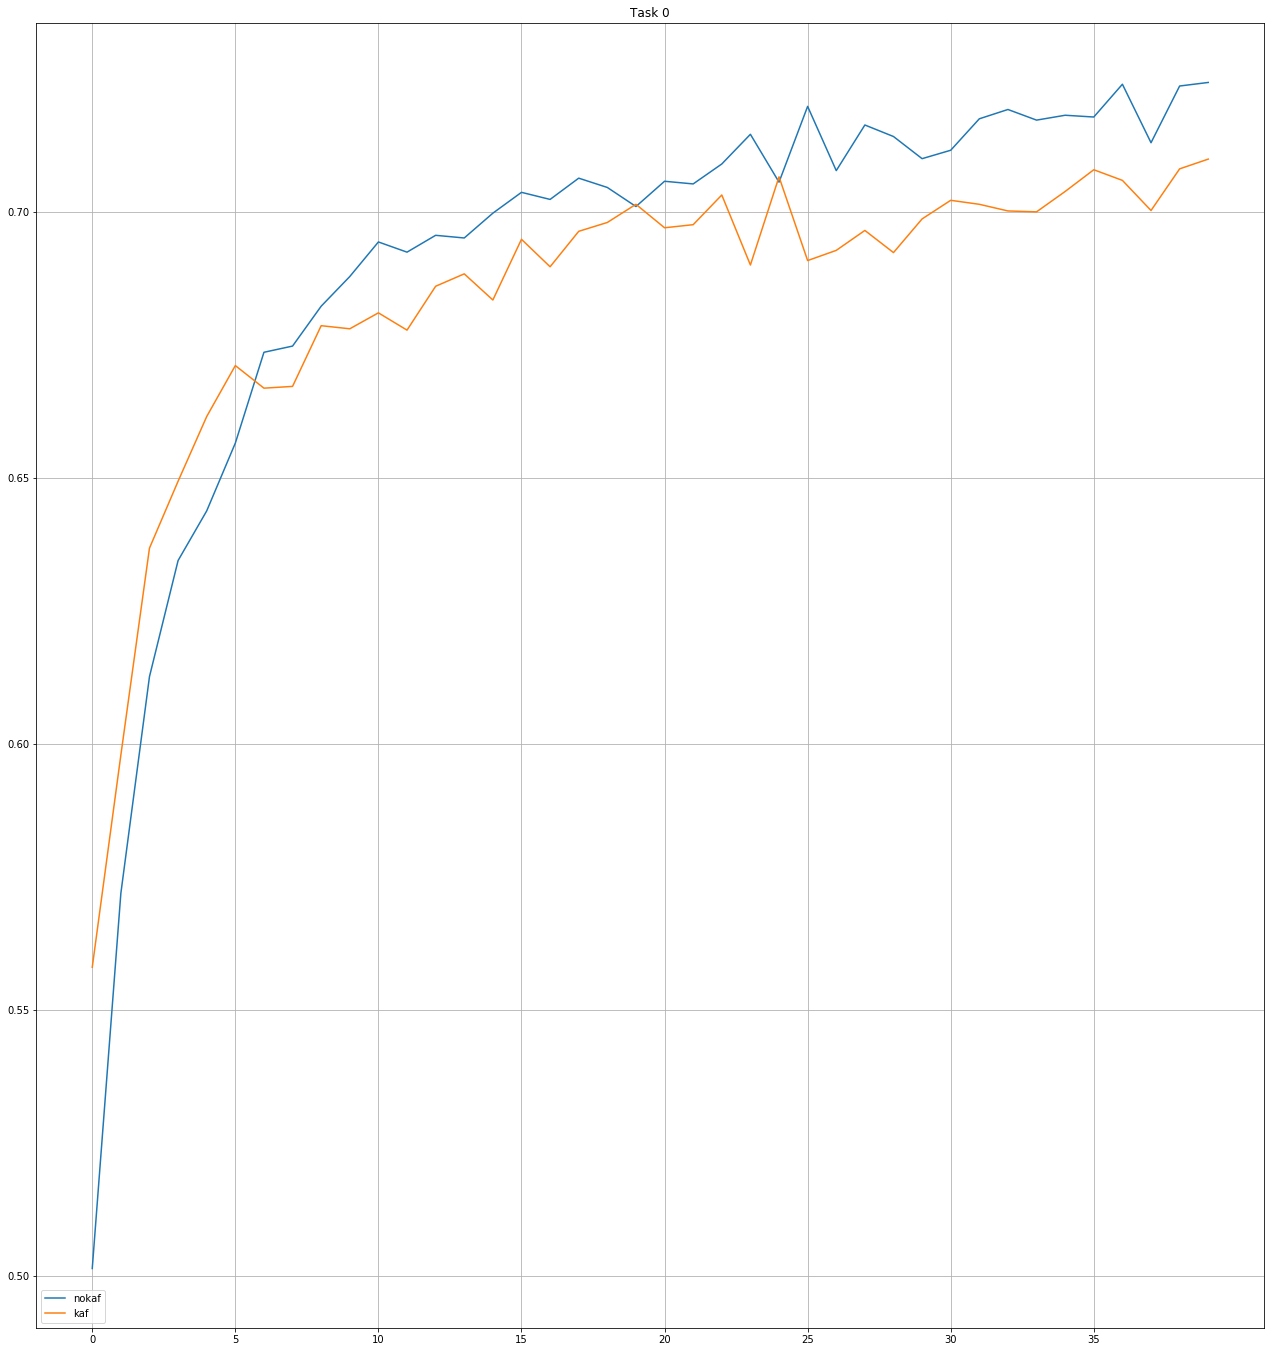

In [12]:
n_task = len(results[0][1]['tasks'])

tot_epochs = 0

for _, r in results:
    for k, v in r['tasks'].items():
        tot_epochs = max(tot_epochs, len(v['accuracy']))
      
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(22, 24), sharex=True, sharey=True)

for name, r in results:
    for i, task in enumerate(r['tasks'].keys()):

        com = r['tasks'][task]
        #no_ewt = metrics_no_ewt['tasks'][task]

        x = range(tot_epochs-len(com['accuracy']), tot_epochs)

        #ax = fig.add_subplot(n_task, 1, i+1, sharex=ax) 

        ax.plot(x, com['accuracy'], label=name)
        #ax.plot(x, no_ewt['accuracy'], label='online ewt')

        ax.set_xticks(range(0, tot_epochs, 5),minor=False)

        ax.set_title("Task {}".format(task))
        ax.legend(loc="lower left")
        ax.grid(True, axis='both')

        
fig.subplots_adjust(hspace=0.1, wspace=0.01)
